# PCA Excercise (Core)

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns',200)
pd.set_option("display.max_info_rows", 800)
pd.set_option('display.max_info_columns',800)

from sklearn import set_config
set_config(transform_output='pandas')

import warnings
warnings.filterwarnings("ignore")

### Functions

In [2]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [3]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

### Data Prep

In [4]:
df = pd.read_csv('data/NHANES_Diet_Diabetes_Risk.xls.csv')
df = df.set_index("SEQN")
df.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73557,16888.32786,12930.89065,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.0,70.0,110.0,60.0,304.0,278.0,1398.0,430.0,1.057,1.216,11.804,0.951,285.0,66.0,219.0,330.0,216.3,2.79,0.00,241.4,3.3,29.2,949.0,756.0,206.0,8.41,8.85,1.072,1323.0,2228.0,62.5,203.0,36.0,0.0,2701.79,0.219,0.099,0.103,0.153,0.346,1.221,9.694,5.408,1.173,16.796,0.121,0.001,7.932,0.769,0.000,0.094,0.001,0.000,0.010,2.0,960.0,960.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
73558,17932.14387,12684.14887,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.0,1477.0,1488.0,0.0,145.0,12.0,0.0,899.0,4.178,5.168,65.396,4.415,1243.0,601.0,641.0,1662.0,2149.0,21.45,0.00,2.3,15.2,23.4,3193.0,6427.0,903.0,26.88,30.36,4.130,9726.0,4930.0,715.8,240.0,0.0,119.0,6779.99,1.872,1.160,0.802,1.286,1.297,6.516,27.952,12.107,2.208,32.429,0.086,0.000,15.483,1.774,0.007,0.728,1.003,0.104,1.139,2.0,360.0,360.0,0.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
73559,59641.81293,39394.23671,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.0,616.0,655.0,21.0,449.0,35.0,515.0,300.0,1.648,1.747,18.342,1.906,423.0,290.0,133.0,625.0,161.2,3.78,1.42,195.1,4.0,40.4,877.0,1198.0,210.0,17.57,8.98,0.949,2943.0,1694.0,98.3,45.0,71.0,0.0,3766.70,0.358,0.128,0.371,0.455,3.008,2.067,10.691,7.497,0.531,19.910,0.164,0.005,11.705,1.092,0.000,0.042,0.001,0.006,0.002,2.0,1254.0,0.0,1254.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6643 entries, 73557 to 83729
Data columns (total 168 columns):
 #    Column         Dtype  
---   ------         -----  
 0    WTDRD1         float64
 1    WTDR2D         float64
 2    DR1DRSTZ       int64  
 3    DR1EXMER       float64
 4    DRABF          float64
 5    DRDINT         float64
 6    DR1DBIH        float64
 7    DR1DAY         float64
 8    DR1LANG        float64
 9    DR1MNRSP       float64
 10   DR1HELPD       float64
 11   DBQ095Z        float64
 12   DBD100         float64
 13   DRQSPREP       float64
 14   DR1STY         float64
 15   DR1SKY         float64
 16   DRQSDIET       float64
 17   DRQSDT1        float64
 18   DRQSDT2        float64
 19   DRQSDT3        float64
 20   DRQSDT4        float64
 21   DRQSDT5        float64
 22   DRQSDT6        float64
 23   DRQSDT7        float64
 24   DRQSDT8        float64
 25   DRQSDT9        float64
 26   DRQSDT10       float64
 27   DRQSDT11       float64
 28   DRQSDT12   

In [6]:
df.dtypes.value_counts()

float64    166
int64        2
dtype: int64

In [7]:
df.isna().sum().sum()

432597

In [8]:
# Define Target, X, Y
target = 'Diabetes_Risk'
y = df[target].copy()
X = df.drop(columns=target).copy()

In [9]:
# Train/Test Split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=321)
X_train.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
74781,34584.687590,0.000000,1,49.0,2.0,1.0,20.0,5.0,1.0,1.0,13.0,1.0,1.0,4.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,1337.0,35.82,159.57,82.60,13.4,65.13,14.519,22.719,23.924,250.0,6.89,0.00,159.0,706.0,2030.0,5500.0,76.0,3012.0,1173.0,0.803,1.083,11.731,0.937,216.0,67.0,149.0,263.0,249.2,1.57,0.00,81.5,2.8,128.7,371.0,759.0,165.0,7.28,4.49,0.640,2160.0,1623.0,50.6,75.0,8.0,0.0,1370.86,0.124,0.064,0.042,0.083,0.094,0.428,8.899,4.285,0.362,22.081,0.212,0.003,21.184,2.452,0.000,0.148,0.005,0.009,0.037,3.0,507.0,0.0,507.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
76977,15205.564340,24452.373790,1,2.0,2.0,2.0,9.0,5.0,1.0,1.0,13.0,1.0,3.0,4.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1561.0,75.97,140.12,46.73,7.7,67.21,21.706,26.472,13.569,251.0,6.98,0.00,180.0,188.0,5.0,73.0,10.0,157.0,318.0,0.858,2.006,24.328,1.302,225.0,67.0,159.0,272.0,255.6,2.34,0.00,4.5,4.9,17.4,799.0,1269.0,177.0,6.63,5.43,0.591,3318.0,1691.0,118.7,3.0,78.0,14.0,904.93,0.480,0.311,0.209,0.446,0.782,1.989,11.369,4.806,1.374,24.223,0.456,0.051,11.680,1.572,0.002,0.148,0.008,0.015,0.009,3.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,5.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
79530,4940.540826,13796.381440,1,49.0,2.0,2.0,23.0,6.0,1.0,1.0,13.0,1.0,2.0,3.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,1748.0,47.34,256.44,131.76,9.3,60.71,24.015,23.084,10.053,143.0,4.93,1.27,640.0,649.0,0.0,110.0,5.0,0.0,255.0,1.317,1.913,18.543,1.824,271.0,197.0,73.0,408.0,157.5,3.65,1.69,37.7,3.7,41.1,760.0,1231.0,206.0,13.08,6.42,0.783,5654.0,1593.0,68.9,9.0,191.0,0.0,1202.76,0.422,0.263,0.262,0.458,1.875,2.031,12.345,5.729,1.340,21.233,0.259,0.025,8.849,1.089,0.004,0.042,0.011,0.005,0.008,2.0,0.0,0.0,0.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,2.0,2.0,NaN,2.0,NaN,2.0,1.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,Na

In [10]:
# Pipeline
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
pipe = make_pipeline(impute_median, scaler)

In [11]:
# Fit
pipe.fit(X_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [12]:
# Transform
X_train_tf = pipe.transform(X_train)
X_test_tf = pipe.transform(X_test)
X_test_tf.isna().sum().sum()

0

### Model - No PCA

In [13]:
# Fit KNN
knn = KNeighborsClassifier()
knn.fit(X_train_tf, y_train)

KNeighborsClassifier()

In [14]:
%%time
preds = knn.predict(X_test_tf)

CPU times: total: 1.22 s
Wall time: 398 ms


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      4106
           1       0.59      0.05      0.09       430
           2       0.62      0.04      0.07       446

    accuracy                           0.83      4982
   macro avg       0.68      0.36      0.35      4982
weighted avg       0.79      0.83      0.76      4982



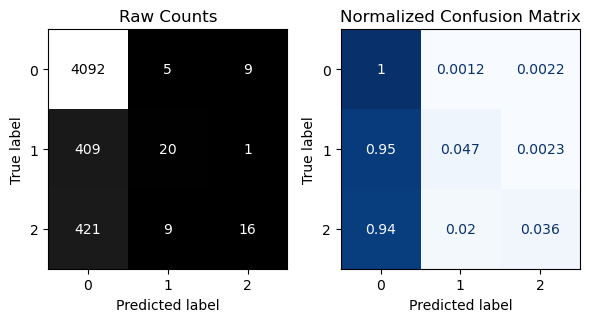


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1346
           1       0.30      0.02      0.04       157
           2       0.11      0.01      0.01       158

    accuracy                           0.80      1661
   macro avg       0.41      0.34      0.31      1661
weighted avg       0.70      0.80      0.73      1661



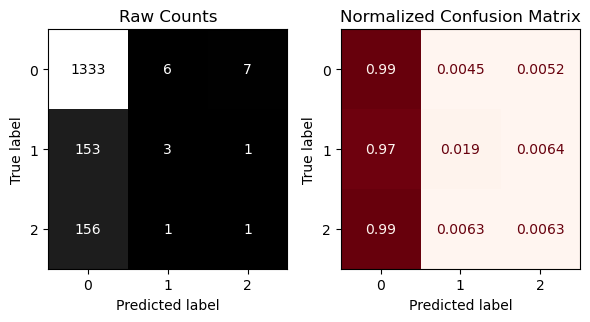

In [15]:
evaluate_classification(knn, X_train_tf,y_train, X_test_tf, y_test)

### PCA Transform / Model

In [16]:
# fitting data to preprocessing pipeline
pipe.fit(df)
scaled_df = pipe.transform(df)
scaled_df.isna().sum().sum()

0

In [17]:
# Define Target, X, Y
target = 'Diabetes_Risk'
y = scaled_df[target].copy()
X = scaled_df.drop(columns=target).copy()

In [18]:
# Train/Test Split
X_train_pca,X_test_pca,y_train_pca,y_test_pca = train_test_split(X,y, random_state=321)
X_train_pca.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
74781,-0.094555,-0.740807,-0.296272,0.250981,0.0,-2.961270,0.362170,0.238153,-0.257978,-0.071277,0.083019,-0.193117,-1.189885,0.678608,0.203192,-0.046604,-1.474103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.772105,-0.765365,-0.999511,-0.749141,-0.365728,-0.293720,-0.323929,-0.701363,-0.296728,0.405578,-0.155308,-0.235920,-0.187241,-0.635916,0.217370,1.553307,0.861665,-0.018079,-0.189976,-0.075244,-0.871010,-0.725688,-0.816655,-0.656205,-0.694340,-0.598629,-0.429976,-0.689304,-0.369863,-0.653930,-0.325162,0.054915,-0.309473,0.129629,-0.968542,-0.850179,-0.811353,-0.821283,-0.924388,-0.731824,-0.729393,-0.732055,-0.938446,-0.265999,-0.311497,-0.305989,-0.926130,-0.735264,-0.779259,-0.792184,-0.912493,-0.574061,-0.950380,-0.610305,-0.493301,-0.861071,-0.194150,-0.339267,-0.256293,0.404471,0.550865,-0.278928,-0.060860,-0.242701,-0.401639,-0.136901,1.067554,-0.467894,-0.544965,0.053095,-0.247386,-0.762827,0.247007,-0.12671,0.327081,-0.145597,0.156595,-0.061119,0.242864,-0.097152,0.191079,-0.103197,0.203435,-0.078037,0.228633,-0.098889,-0.251775,-0.831801,0.172056,-0.082714,0.047572,-0.026167,0.0,-0.476016,0.268273,-0.139528,-1.818802,-0.897336,0.123626,-0.061365,0.335198,-0.014328,0.279704,0.015171,0.188525,-0.036047,0.158601,-0.082036,0.113167,-0.011608,0.111795,-0.067635,0.038828,-0.023193,0.136208,-0.062326,0.068472,0.001718,0.527948,-0.109904,0.172056,-0.080071,0.109001,-0.050695,0.034724,-0.020453,0.092204,-0.034784,0.153026,-0.08124,0.058943,-0.029377,0.415748,-0.095872,0.205831,-0.027807,0.0
76977,-0.588926,-0.290365,-0.296272,-2.132130,0.0,0.337693,-0.624110,0.238153,-0.257978,-0.071277,0.083019,-0.193117,1.751836,0.678608,-1.220653,-0.046604,0.168928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.428060,-0.536787,-0.110145,-0.906660,-0.842161,-0.853305,-0.278675,-0.251755,-0.077524,-0.404729,-0.151126,-0.223959,-0.187241,-0.580740,-0.728025,-0.304622,-0.449941,-0.195464,-0.545429,-0.335103,-0.809710,-0.021919,-0.068832,-0.445768,-0.658511,-0.598629,-0.360327,-0.664646,-0.338504,-0.496931,-0.325162,-0.836032,0.063355,-0.568522,-0.226054,-0.114879,-0.731574,-0.897990,-0.786339,-0.800059,-0.076410,-0.676071,0.061246,-0.697974,0.507810,0.262515,-1.251027,0.035056,0.063902,-0.145678,-0.072965,-0.008644,-0.068061,-0.319137,-0.361199,0.412353,-0.058917,0.469181,0.257395,-0.425004,-0.113045,-0.220583,-0.060860,-0.213542,-0.240728,-0.286593,1.067554,-0.917751,-0.544965,-

In [19]:
pca = PCA(n_components=.95)
X_train_pca = pca.fit_transform(X_train_tf)
X_test_pca = pca.transform(X_test_tf)

In [20]:
pca.n_components_

99

In [21]:
# Fit KNN
knn_pca = KNeighborsClassifier()
knn_pca.fit(X_train_pca,y_train)

KNeighborsClassifier()

In [22]:
%%time
preds_pca = knn_pca.predict(X_test_pca)

CPU times: total: 1.27 s
Wall time: 170 ms


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      4106
           1       0.59      0.05      0.09       430
           2       0.55      0.04      0.07       446

    accuracy                           0.83      4982
   macro avg       0.66      0.36      0.35      4982
weighted avg       0.79      0.83      0.76      4982



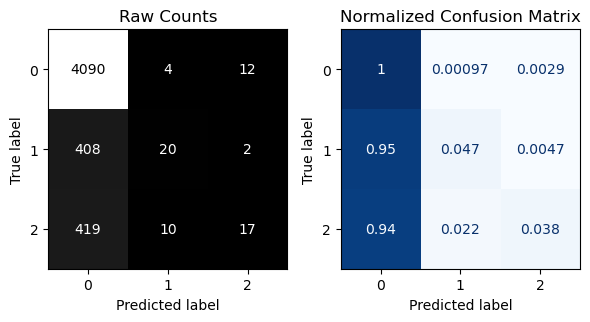


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1346
           1       0.50      0.04      0.07       157
           2       0.11      0.01      0.01       158

    accuracy                           0.81      1661
   macro avg       0.48      0.35      0.33      1661
weighted avg       0.72      0.81      0.73      1661



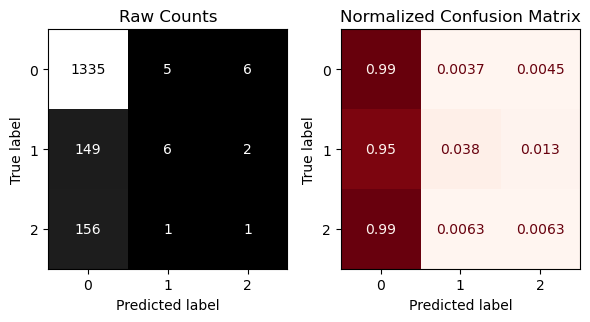

In [23]:
evaluate_classification(knn_pca, X_train_pca,y_train, X_test_pca, y_test)

### Comparing Models

##### How many features were used in the first model, and how many PCs were used in the PCA model?
- 168 in the first model

- 99 in the PCA model

##### Which model performed the best on the test set?
- Both Models performed similarly

##### Which model was the fastest at making predictions?
- In this case they performed in very similar time, with the non-PCA model slightly faster